In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Dataset

In [9]:
import tarfile
from PIL import Image
import os
import torch
import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

class MNIST(Dataset):
    """
    MNIST dataset for loading and transforming MNIST images from tar files.

    Args:
        data_dir (str): Path to the tar file containing images.
    """

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_open = tarfile.open(data_dir, 'r')
        self.png_files = [file for file in self.file_open.getmembers() if file.isfile()]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.3081])
        ])

    def __len__(self):
        return len(self.png_files)

    def __getitem__(self, idx):
        member = self.png_files[idx]
        label = int(member.name.split('_')[1].split('.')[0])

        file = self.file_open.extractfile(member)
        image = Image.open(io.BytesIO(file.read())).convert('L')
        image = self.transform(image)
        label = torch.tensor(label)
        return image, label

if __name__ == '__main__':
    # Define paths to the tar files for training and testing datasets
    train_data_dir = '/content/gdrive/MyDrive/AI/train.tar'
    test_data_dir = '/content/gdrive/MyDrive/AI/test.tar'

    # Create dataset instances
    train_dataset = MNIST(data_dir=train_data_dir)
    test_dataset = MNIST(data_dir=test_data_dir)

    # Create DataLoader instances
    train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Example of fetching a batch of data
    images, labels = next(iter(train_data_loader))
    print(images.size())  # torch.Size([64, 1, 28, 28])
    print(labels.size())  # torch.Size([64])

torch.Size([64, 1, 28, 28])
torch.Size([64])


### Model
* Input Layer : 32x32
* C1 (Convolution) : 28x28x6
* S2 (Subsampling) : 14x14x6
* C3 (Convolution) : 10x10x16
* S4 (Subsampling) : 5x5x16
* C5 (Fully connection) : Layer 120 => classifier
* F6 (Fully Connection) : Layer 84 => classifier
* Output (Gaussian connections) : 10

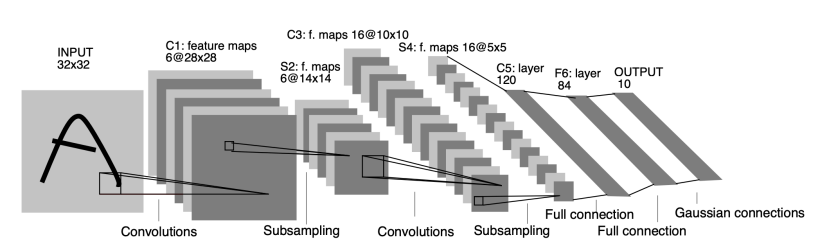

In [10]:
""" LeNet-5 (LeCun et al., 1998)

        - For a detailed architecture, refer to the lecture note
        - Freely choose activation functions as you want
        - For subsampling, use max pooling with kernel_size = (2,2)
        - Output should be a logit vector
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # Input is 1x28x28, output is 6x28x28
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)            # Input is 6x14x14, output is 16x10x10
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)          # Input is 16x5x5, output is 120x1x1
        self.fc1 = nn.Linear(120, 84)                           # Fully connected layers
        self.fc2 = nn.Linear(84, 10)                            # Output layer (10 classes for MNIST)

    def forward(self, img):
        img = F.max_pool2d(F.relu(self.conv1(img)), (2, 2))  # First subsampling
        img = F.max_pool2d(F.relu(self.conv2(img)), (2, 2))  # Second subsampling
        img = F.relu(self.conv3(img))
        img = img.view(-1, self.num_flat_features(img))
        img = F.relu(self.fc1(img))
        img = self.fc2(img)
        return img

    def num_flat_features(self, img):
        size = img.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


""" Your custom MLP model

    - Note that the number of model parameters should be about the same
      with LeNet-5
"""

class CustomMLP(nn.Module):
    def __init__(self):
        super(CustomMLP, self).__init__()
        input_size = 28*28  # MNIST images are 28x28 pixels
        hidden1_size = 70  # First hidden layer size
        hidden2_size = 55   # Second hidden layer size
        hidden3_size = 28   # Third hidden layer size
        output_size = 10    # MNIST has 10 classes (0-9)

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_size, output_size)

    def forward(self, img):
        img = img.view(-1, 28*28)  # Flatten the image
        img = self.relu1(self.fc1(img))
        img = self.relu2(self.fc2(img))
        img = self.relu3(self.fc3(img))
        img = self.fc4(img)
        return img


class RegularizedLenet5(nn.Module):
    def __init__(self):
        super(RegularizedLenet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)  # 배치 정규화 적용
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)  # 배치 정규화 적용
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.dropout1 = nn.Dropout(0.5)  # 드롭아웃 적용
        self.fc2 = nn.Linear(84, 10)

    def forward(self, img):
        img = F.max_pool2d(F.relu(self.bn1(self.conv1(img))), (2, 2))
        img = F.max_pool2d(F.relu(self.bn2(self.conv2(img))), (2, 2))
        img = F.relu(self.conv3(img))
        img = img.view(-1, self.num_flat_features(img))
        img = F.relu(self.fc1(img))
        img = self.dropout1(img)  # 드롭아웃 적용
        img = self.fc2(img)
        return img

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Main

Epoch 1, LeNet5 Train Loss: 0.3112, Accuracy: 89.85%
Epoch 1, LeNet5 Test Loss: 0.0549, Accuracy: 98.34%
Epoch 2, LeNet5 Train Loss: 0.0646, Accuracy: 97.98%
Epoch 2, LeNet5 Test Loss: 0.0579, Accuracy: 98.23%
Epoch 3, LeNet5 Train Loss: 0.0461, Accuracy: 98.54%
Epoch 3, LeNet5 Test Loss: 0.0407, Accuracy: 98.67%
Epoch 4, LeNet5 Train Loss: 0.0372, Accuracy: 98.84%
Epoch 4, LeNet5 Test Loss: 0.0380, Accuracy: 98.76%
Epoch 5, LeNet5 Train Loss: 0.0299, Accuracy: 99.06%
Epoch 5, LeNet5 Test Loss: 0.0338, Accuracy: 98.88%
Epoch 6, LeNet5 Train Loss: 0.0240, Accuracy: 99.19%
Epoch 6, LeNet5 Test Loss: 0.0347, Accuracy: 98.91%
Epoch 7, LeNet5 Train Loss: 0.0205, Accuracy: 99.31%
Epoch 7, LeNet5 Test Loss: 0.0312, Accuracy: 99.05%
Epoch 8, LeNet5 Train Loss: 0.0168, Accuracy: 99.45%
Epoch 8, LeNet5 Test Loss: 0.0290, Accuracy: 99.19%
Epoch 9, LeNet5 Train Loss: 0.0163, Accuracy: 99.43%
Epoch 9, LeNet5 Test Loss: 0.0425, Accuracy: 98.80%
Epoch 10, LeNet5 Train Loss: 0.0144, Accuracy: 99.48%
E

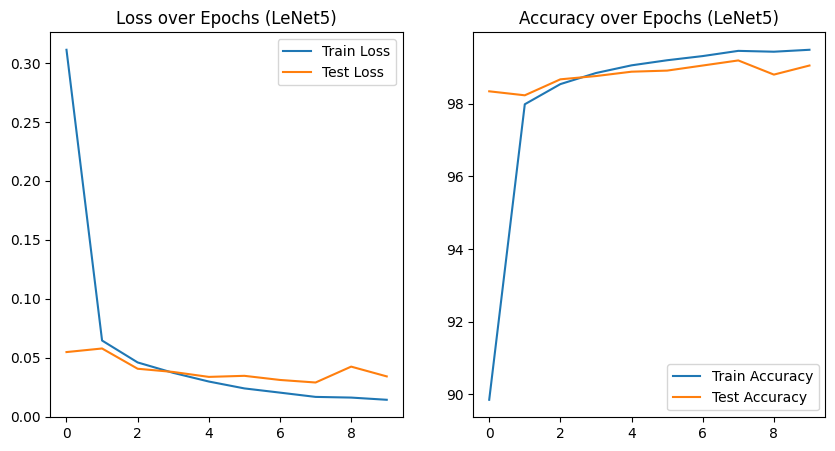

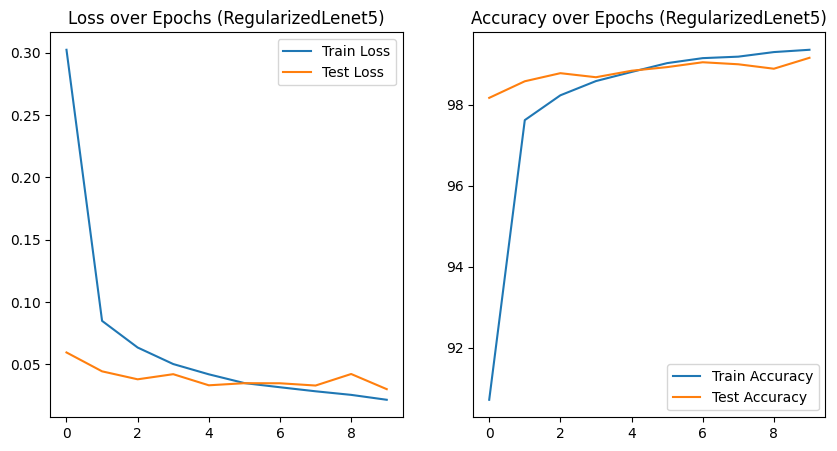

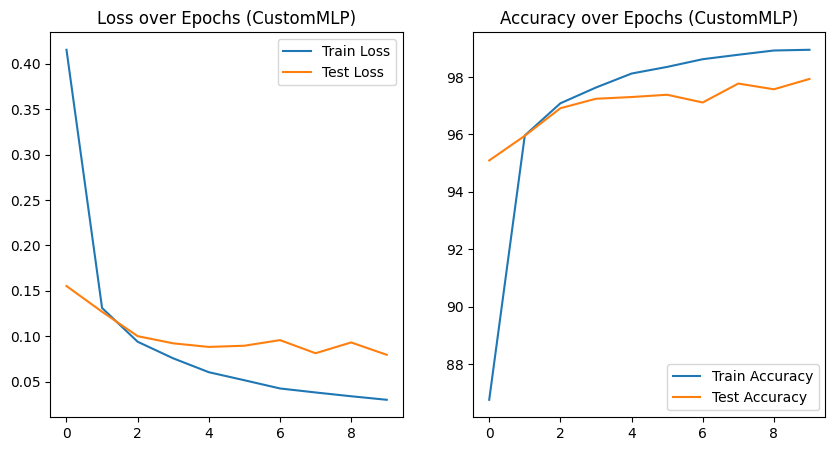

In [11]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train(model, trn_loader, device, criterion, optimizer):
    model.train()
    trn_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trn_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        trn_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    trn_loss = trn_loss / len(trn_loader)
    acc = 100. * correct / total
    return trn_loss, acc

def test(model, tst_loader, device, criterion):
    model.eval()
    tst_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tst_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            tst_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    tst_loss = tst_loss / len(tst_loader)
    acc = 100. * correct / total
    return tst_loss, acc

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create dataset instances and dataloaders
    train_data_dir = '/content/gdrive/MyDrive/AI/train.tar'
    test_data_dir = '/content/gdrive/MyDrive/AI/test.tar'
    train_dataset = MNIST(data_dir=train_data_dir)
    test_dataset = MNIST(data_dir=test_data_dir)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model, Loss, Optimizer
    models = {'LeNet5': LeNet5(), 'RegularizedLenet5': RegularizedLenet5(), 'CustomMLP': CustomMLP()}
    criterion = nn.CrossEntropyLoss()
    stats = {}

    for name, model in models.items():
        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        trn_loss_list, tst_loss_list, trn_acc_list, tst_acc_list = [], [], [], []

        for epoch in range(10):  # run for 10 epochs
            trn_loss, trn_acc = train(model, train_loader, device, criterion, optimizer)
            tst_loss, tst_acc = test(model, test_loader, device, criterion)

            trn_loss_list.append(trn_loss)
            tst_loss_list.append(tst_loss)
            trn_acc_list.append(trn_acc)
            tst_acc_list.append(tst_acc)

            print(f'Epoch {epoch+1}, {name} Train Loss: {trn_loss:.4f}, Accuracy: {trn_acc:.2f}%')
            print(f'Epoch {epoch+1}, {name} Test Loss: {tst_loss:.4f}, Accuracy: {tst_acc:.2f}%')

        stats[name] = (trn_loss_list, tst_loss_list, trn_acc_list, tst_acc_list)

    # Plotting
    for name, (trn_loss_list, tst_loss_list, trn_acc_list, tst_acc_list) in stats.items():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(trn_loss_list, label='Train Loss')
        plt.plot(tst_loss_list, label='Test Loss')
        plt.title(f'Loss over Epochs ({name})')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(trn_acc_list, label='Train Accuracy')
        plt.plot(tst_acc_list, label='Test Accuracy')
        plt.title(f'Accuracy over Epochs ({name})')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()